# Implementando uma GRU com Grid Search para escolher melhor os parâmetros no Mapa Logístico

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 125

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

### 1.2 Bibliotecas para GRU

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

from tensorflow import keras

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [4]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [5]:
from pibic2020.models import gru_model

### 1.3 Bibliotecas dos sistemas caóticos

In [6]:
from pibic2020.data import logistic
from pibic2020.tools import timeseries

## 2. Gerando a série temporal do mapa logístico

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original. Utilizaremos  $r = 3.86$, o que faz com que o sistema esteja em caos.

In [7]:
x_inicial = 0.5
n_inicial = 0
n_iteracoes = 5000
r=3.86
estados = np.array([x_inicial, n_inicial])

In [8]:
mapa = logistic.MapaLogistico(estado_inicial=estados, r=r)

In [9]:
for n in range(0, n_iteracoes):
    mapa.iterar()
    estados = np.vstack((estados, mapa.ler_estado()))

In [10]:
x = estados[:, 0]
n = estados[:, 1]

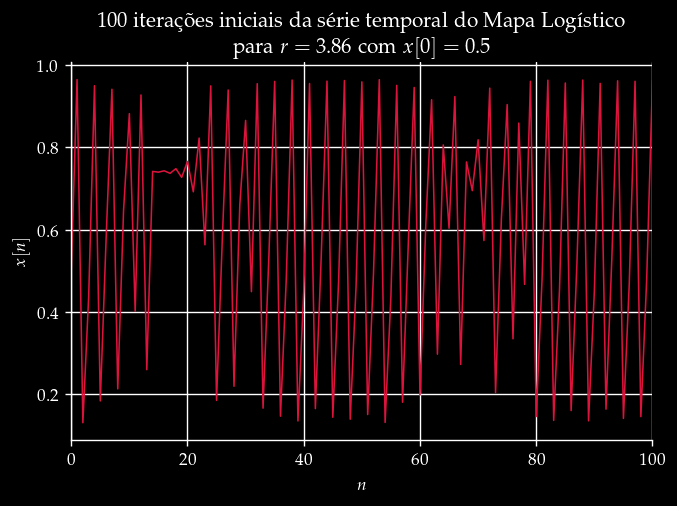

In [11]:
fig, ax = plt.subplots()
ax.plot(n, x, color='Crimson', linewidth=0.9)

ax.set_title("$100$ iterações iniciais da série temporal do Mapa Logístico\n para $r =$ " + str(r) + " com $x[0] =$ " + str(x[0]))
ax.set_ylabel('$x[n]$')
ax.set_xlabel('$n$')
ax.set_xlim(0,100)
    
ax.grid(True)
sns.despine()

plt.show()

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [12]:
K = 4
L = 1
tam_teste = 0.15

In [13]:
serie_temporal = timeseries.SerieTemporal(x, K=K, L=L)

In [14]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

### 2.2 Pré-processamento nos dados de entrada

In [15]:
len_treino = X_treino.shape[0]
len_teste = X_teste.shape[0]
n_samples = X_treino.shape[1]

In [16]:
X_treino = np.reshape(X_treino,(len_treino, n_samples, 1))
X_teste = np.reshape(X_teste,(len_teste, n_samples, 1))

## 3. Definindo o modelo para a GRU e executando os Gridsearches

In [17]:
holdout = TimeSeriesSplit(n_splits=4, test_size=int(0.1*len(y_treino)), gap=0)

### 3.1 Criando o objeto da GRU

In [18]:
gru_gridsearch = gru_model.ModeloGRU(input_shape = (K, 1))

Utilizaremos os seguintes parâmetros no *Grid Search*:

In [19]:
param_grid = dict(batch_size=[2, 4, 8, 16, 32], 
                  init_mode = ['glorot_normal', 'glorot_uniform'],
                  n_units = [5, 10, 15, 20, 30, 50, 75, 100],
                  learning_rate = [0.001, 0.003, 0.005, 0.008, 0.01])

Para facilitar, dividiremos esse processo em etapas.

### 3.2 Definindo parâmetros que não serão definidos pelo *Grid Search*

In [20]:
loss = "mean_squared_error"
optimizer = keras.optimizers.Nadam()

### 3.3 Definindo e executando o primeiro *Grid Search*

Primeiro, avaliaremos o impacto do *batch size*.

In [21]:
param_grid_1 = dict(batch_size=[2, 4, 8, 16, 32])

In [22]:
model_cv_1 = KerasRegressor(build_fn=gru_gridsearch.gridsearch, epochs=100, verbose=0)

In [23]:
grid = GridSearchCV(estimator=model_cv_1, param_grid=param_grid_1, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [24]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END .......................................batch_size=2; total time= 3.1min
[CV] END .......................................batch_size=2; total time= 3.7min
[CV] END .......................................batch_size=2; total time= 3.9min
[CV] END .......................................batch_size=2; total time= 4.4min
[CV] END .......................................batch_size=4; total time= 1.5min
[CV] END .......................................batch_size=4; total time= 1.7min
[CV] END .......................................batch_size=4; total time= 2.0min
[CV] END .......................................batch_size=4; total time= 2.2min
[CV] END .......................................batch_size=8; total time=  45.1s
[CV] END .......................................batch_size=8; total time=  52.6s
[CV] END .......................................batch_size=8; total time=  59.2s
[CV] END .......................................b

In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000526 using {'batch_size': 2}


In [26]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000526 (0.000159) with: {'batch_size': 2}
-0.001196 (0.000641) with: {'batch_size': 4}
-0.006262 (0.005841) with: {'batch_size': 8}
-0.019278 (0.010424) with: {'batch_size': 16}
-0.035197 (0.005375) with: {'batch_size': 32}


### 3.4 Definindo e executando o segundo *Grid Search*

Agora, avaliaremos o impacto do *learning rate* do otimizador.

In [21]:
model_cv_2 = KerasRegressor(build_fn=gru_gridsearch.gridsearch, epochs=100, verbose=0, batch_size=2)

In [22]:
param_grid_2 = dict(learning_rate=[0.001, 0.003, 0.005, 0.008, 0.01])

In [23]:
grid = GridSearchCV(estimator=model_cv_2, param_grid=param_grid_2, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [24]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END ................................learning_rate=0.001; total time= 3.1min
[CV] END ................................learning_rate=0.001; total time= 3.5min
[CV] END ................................learning_rate=0.001; total time= 3.9min
[CV] END ................................learning_rate=0.001; total time= 4.4min
[CV] END ................................learning_rate=0.003; total time= 3.0min
[CV] END ................................learning_rate=0.003; total time= 3.4min
[CV] END ................................learning_rate=0.003; total time= 4.0min
[CV] END ................................learning_rate=0.003; total time= 4.4min
[CV] END ................................learning_rate=0.005; total time= 3.0min
[CV] END ................................learning_rate=0.005; total time= 3.4min
[CV] END ................................learning_rate=0.005; total time= 4.0min
[CV] END ................................learning

In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000807 using {'learning_rate': 0.005}


In [26]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000932 (0.000566) with: {'learning_rate': 0.001}
-0.000821 (0.000274) with: {'learning_rate': 0.003}
-0.000807 (0.000491) with: {'learning_rate': 0.005}
-0.011425 (0.017482) with: {'learning_rate': 0.008}
-0.001549 (0.000810) with: {'learning_rate': 0.01}


### 3.5 Definindo e executando o terceiro *Grid Search*

Agora, avaliaremos o impacto do inicializador da camada intermediária, considerando a $\tanh$ como função de ativação.

In [27]:
model_cv_3 = KerasRegressor(build_fn=gru_gridsearch.gridsearch, epochs=100, verbose=0, batch_size=2, learning_rate=0.003)

In [28]:
param_grid_3 = dict(init_mode = ['glorot_uniform', 'glorot_normal'])

In [29]:
grid = GridSearchCV(estimator=model_cv_3, param_grid=param_grid_3, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [30]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END ...........................init_mode=glorot_uniform; total time= 3.0min
[CV] END ...........................init_mode=glorot_uniform; total time= 3.5min
[CV] END ...........................init_mode=glorot_uniform; total time= 3.9min
[CV] END ...........................init_mode=glorot_uniform; total time= 4.5min
[CV] END ............................init_mode=glorot_normal; total time= 2.9min
[CV] END ............................init_mode=glorot_normal; total time= 3.4min
[CV] END ............................init_mode=glorot_normal; total time= 4.0min
[CV] END ............................init_mode=glorot_normal; total time= 4.5min


In [31]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000587 using {'init_mode': 'glorot_normal'}


In [32]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.001154 (0.000500) with: {'init_mode': 'glorot_uniform'}
-0.000587 (0.000237) with: {'init_mode': 'glorot_normal'}


### 3.6 Definindo e executando o quarto *Grid Search*

Agora, avaliaremos o número de unidades *GRU* na camada intermediária.

In [33]:
model_cv_4 = KerasRegressor(build_fn=gru_gridsearch.gridsearch, epochs=100, verbose=0, batch_size=2, learning_rate=0.003, init_mode='glorot_normal')

In [34]:
param_grid_4 = dict(n_units = [5, 10, 15, 20, 30, 50, 75, 100])

In [35]:
grid = GridSearchCV(estimator=model_cv_4, param_grid=param_grid_4, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [36]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] END ..........................................n_units=5; total time= 3.0min
[CV] END ..........................................n_units=5; total time= 3.5min
[CV] END ..........................................n_units=5; total time= 4.0min
[CV] END ..........................................n_units=5; total time= 4.4min
[CV] END .........................................n_units=10; total time= 3.0min
[CV] END .........................................n_units=10; total time= 3.4min
[CV] END .........................................n_units=10; total time= 4.0min
[CV] END .........................................n_units=10; total time= 4.5min
[CV] END .........................................n_units=15; total time= 2.9min
[CV] END .........................................n_units=15; total time= 3.5min
[CV] END .........................................n_units=15; total time= 4.0min
[CV] END ........................................

In [37]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000334 using {'n_units': 100}


In [38]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.004856 (0.004375) with: {'n_units': 5}
-0.003774 (0.002374) with: {'n_units': 10}
-0.001286 (0.000865) with: {'n_units': 15}
-0.001000 (0.000694) with: {'n_units': 20}
-0.001042 (0.000560) with: {'n_units': 30}
-0.001231 (0.000474) with: {'n_units': 50}
-0.000512 (0.000155) with: {'n_units': 75}
-0.000334 (0.000069) with: {'n_units': 100}


### Treino com o melhor modelo

#### Dados de entrada

In [39]:
X_treino, X_teste, X_val, y_treino, y_teste, y_val = serie_temporal.dividir_treino_teste_validacao(tam_teste=0.15, tam_val=0.1)

#### Ajuste no modelo

In [40]:
model = gru_model.ModeloGRU(input_shape = (K, 1), name='GRU-logistic')

In [41]:
model.criar_modelo(n_units=100, init_mode='glorot_normal')

In [42]:
model.montar(learning_rate=0.003)

In [43]:
model.visualizar()

Model: "GRU-logistic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_gru (GRU)             (None, 100)               30900     
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.treinar(X_treino, X_val, y_treino, y_val, batch_size=2)

Epoch 1/100
1910/1910 [==============================] - 4s 2ms/step - loss: 0.0652 - val_loss: 0.0462
Epoch 2/100
1910/1910 [==============================] - 6s 3ms/step - loss: 0.0491 - val_loss: 0.0495
Epoch 3/100
1910/1910 [==============================] - 4s 2ms/step - loss: 0.0461 - val_loss: 0.0476
Epoch 4/100
1910/1910 [==============================] - 4s 2ms/step - loss: 0.0428 - val_loss: 0.0440
Epoch 5/100
1910/1910 [==============================] - 5s 3ms/step - loss: 0.0422 - val_loss: 0.0412
Epoch 6/100
1910/1910 [==============================] - 4s 2ms/step - loss: 0.0367 - val_loss: 0.0323
Epoch 7/100
1910/1910 [==============================] - 4s 2ms/step - loss: 0.0329 - val_loss: 0.0251
Epoch 8/100
1910/1910 [==============================] - 5s 3ms/step - loss: 0.0267 - val_loss: 0.0163
Epoch 9/100
1910/1910 [==============================] - 5s 3ms/step - loss: 0.0156 - val_loss: 0.0119
Epoch 10/100
1910/1910 [==============================] - 5s 3ms/step - l

## Teste com o melhor modelo

In [45]:
y_pred = model.predicao(X_teste)

### Gráfico

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


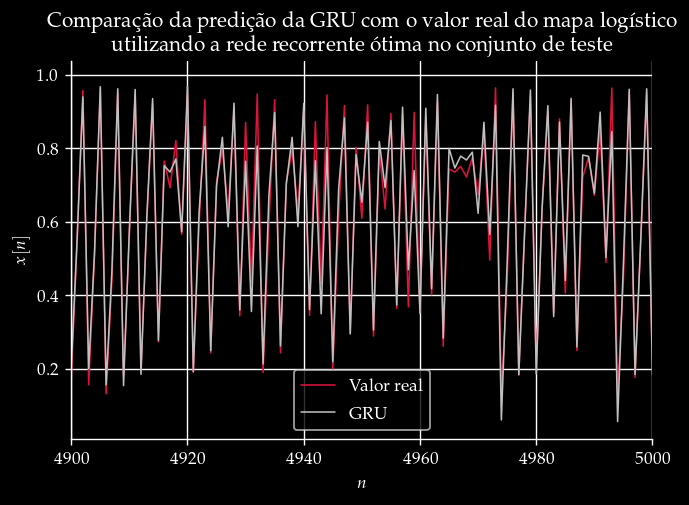

In [46]:
fig, ax = plt.subplots()
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_teste, color='Crimson', label='Valor real', linewidth=0.9)
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_pred, color='Silver', label='GRU', linewidth=0.9)

ax.set_title("Comparação da predição da GRU com o valor real do mapa logístico\n utilizando a rede recorrente ótima no conjunto de teste")
ax.set_ylabel('$x[n]$')
ax.set_xlabel('$n$')
ax.set_xlim(4900, 5000)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()
fig.savefig("../../../images/gru/performance/gru-vs-logistic.png")

### Erro Quadrático Médio

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
mse = mean_squared_error(y_teste, y_pred)
print("MSE = " + str(mse))

MSE = 0.0009509827923540672


### Salvando o Modelo

In [49]:
model.salvar("../../../models/gru/gru-logistic", h5="ON")

O modelo foi salvo!
